In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from toolz import curry
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Get imputed data
RCT_results = pd.read_csv("./predictions.csv")
RCT_results.head(10)

,Unnamed: 0,mort_28,peep_regime,s_learner_ite,t_learner_ite,x_learner_ite
0,0,0.0,1.0,0.001003,0.010109,0.041716
1,1,0.0,0.0,0.002020,0.030801,0.152876
2,2,0.0,0.0,-0.001264,-0.043988,-0.107896
3,3,0.0,0.0,0.000863,0.004214,0.055645
4,4,0.0,1.0,0.001879,0.029268,0.027860
5,5,1.0,0.0,0.002059,0.031558,0.176747
6,6,0.0,1.0,0.000460,-0.002074,0.035183
7,7,0.0,1.0,0.001613,0.019376,0.125406
8,8,0.0,0.0,0.000815,0.003475,0.034752
9,9,0.0,0.0,0.000336,-0.010123,-0.003221


In [4]:
from sklearn.metrics import auc
# Function to calculate the elasticity 
@curry
def elast(data, y, t):
    numerator = np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) 
    denominator = np.sum((data[t] - data[t].mean())**2)
    epsilon = 1e-10
    return numerator/ (denominator + epsilon)    

# Function to calculate the cumulative gain
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    print(ordered_df.head(2000))
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    cumulative_gains = np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])
    baseline_gains = np.linspace(0, elast(dataset, y, t), len(cumulative_gains))
    cumulative_auc = auc(np.arange(len(cumulative_gains)), cumulative_gains)
    baseline_auc = auc(np.arange(len(baseline_gains)), baseline_gains)
    auc_score = cumulative_auc - baseline_auc
    # auc_score = auc(range(1, len(cumulative_gains)+1), cumulative_gains)
    return cumulative_gains, auc_score

In [5]:
# Calculate cumulative gain curve for S, T-, and X-learner (SVR) for CATE esimation on RCT data
gain_curve_rct_s, auc_rct_s = cumulative_gain(RCT_results, "s_learner_ite", y="mort_28", t="peep_regime")
gain_curve_rct_t, auc_rct_t = cumulative_gain(RCT_results, "t_learner_ite", y="mort_28", t="peep_regime")
gain_curve_rct_x, auc_rct_x = cumulative_gain(RCT_results, "x_learner_ite", y="mort_28", t="peep_regime")
elast_curve = elast(RCT_results, "mort_28", "peep_regime")

      Unnamed: 0  mort_28  peep_regime  s_learner_ite  t_learner_ite  \
0            830      1.0          0.0       0.003999       0.082353   
1            180      1.0          1.0       0.003682       0.069910   
2           2172      1.0          1.0       0.003617       0.069809   
3            438      1.0          0.0       0.003410       0.065372   
4            195      1.0          1.0       0.003398       0.066163   
...          ...      ...          ...            ...            ...   
1995         765      1.0          1.0      -0.000178      -0.019059   
1996         466      0.0          0.0      -0.000183      -0.019485   
1997         424      0.0          0.0      -0.000184      -0.021873   
1998        1425      0.0          0.0      -0.000184      -0.023005   
1999         511      0.0          0.0      -0.000188      -0.021327   

      x_learner_ite  
0          0.347556  
1          0.243071  
2          0.254888  
3          0.184995  
4          0.298921  
...

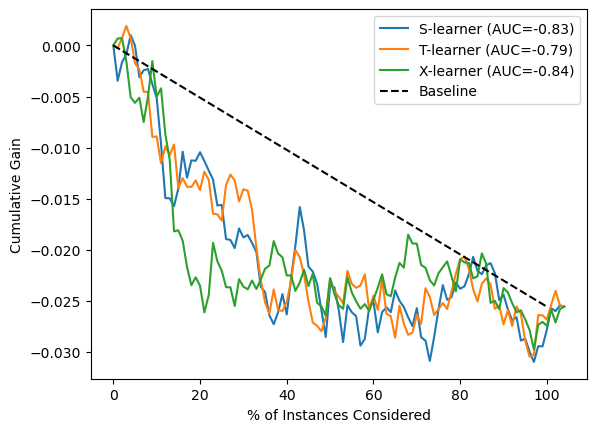

In [6]:
# Plot cumulative gain curves for S-, T-, and X-learner
plt.plot(gain_curve_rct_s, color="C0", label=f"S-learner (AUC={auc_rct_s:.2f})")
plt.plot(gain_curve_rct_t, color="C1", label=f"T-learner (AUC={auc_rct_t:.2f})")
plt.plot(gain_curve_rct_x, color="C2", label=f"X-learner (AUC={auc_rct_x:.2f})")
         
         
plt.plot([0, 100], [0, elast_curve], linestyle="--", color="black", label="Baseline")
plt.xlabel("% of Instances Considered")
plt.ylabel("Cumulative Gain")
plt.legend()

In [7]:
peep_reg = RCT_results['peep_regime'].tolist()
num_treated = peep_reg.count(1)
num_untreated = peep_reg.count(0)

print(num_treated)
print(num_untreated)

print(num_treated/(num_treated+num_untreated))

1136
1163
0.4941278816876903
